# Detecting the difficulty level of French texts




In [1]:
import pandas as pd
import numpy as np

In [2]:
train_data = pd.read_csv('training_data.csv', index_col = 'id')


In [3]:
train_data.head()

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [75]:
train_data['word_count'] = train_data['sentence'].apply(lambda x: len(x.split()))
train_data['word_count'] = train_data['word_count'].apply(lambda x: '.' * x)
train_data.head()

,sentence,difficulty,word_count
id,,,
0,Les coûts kilométriques réels peuvent diverger...,C1,......................................
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,............
2,Le test de niveau en français est sur le site ...,A1,.............
3,Est-ce que ton mari est aussi de Boston?,A1,........
4,"Dans les écoles de commerce, dans les couloirs...",B1,..................................


In [76]:
train_data.isnull().sum()

sentence      0
difficulty    0
word_count    0
dtype: int64

In [77]:
train_data.duplicated().sum()

0

In [78]:
X_data = train_data.drop(['difficulty'], axis = 1)

In [79]:
y_data = train_data['difficulty']

In [8]:
from sklearn.model_selection import train_test_split

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

In [81]:
y_train.shape

(3840,)

In [82]:
X_train.shape

(3840, 2)

In [12]:
import spacy
from spacy import displacy
import string
from nltk.stem.snowball import SnowballStemmer

In [13]:
#french language
french = spacy.load('fr_core_news_sm')
stemmer = SnowballStemmer(language='french')

In [14]:
english = spacy.load('en_core_web_sm')  

In [15]:
test = "Bouygues a eu 1 coupure de réseau à Marseille."
test2 = "Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient "

In [16]:
import string
def spacy_tokenizer(sentence):

    punctuations = string.punctuation
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS

    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = french(sentence)

    mytokens = [word for word in mytokens if word.pos_ != "PROPN"]
#
    ## Lemmatize each token and convert each token into lowercase
    mytokens = [stemmer.stem(X.text) for X in mytokens]
#
    ## Remove numbers
    mytokens = [word for word in mytokens if not word.isdigit()]

    return mytokens

In [17]:
french(test2)

Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient 

In [18]:
english(test2)

Par ailleurs, 42 % des adolescents déclarent qu'ils seraient dévastés s'ils devaient 

In [66]:
spacy_tokenizer(test2)

['par',
 'ailleur',
 ',',
 '%',
 'de',
 'adolescent',
 'déclarent',
 "qu'",
 'il',
 'ser',
 'dévast',
 "s'",
 'il',
 'dev']

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Define the transformers for different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('text', Pipeline([
            ('vect', CountVectorizer(tokenizer=spacy_tokenizer)),
            ('tfidf', TfidfTransformer()),
        ]), 'sentence'),
        ('pass_through', 'passthrough', ['word_count'])
    ],
    remainder='drop'  # Drop any columns not explicitly transformed
)

# Create the final pipeline including DecisionTreeClassifier
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(criterion='entropy', max_depth=5))
])

# Fit the model on the training data
pipe.fit(X_train, y_train)


c:\Users\DENIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


ValueError: For a sparse output, all columns should be a numeric or convertible to a numeric.

In [51]:
y_pred = pipe.predict(X_test)

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

In [52]:
print(f'The accuracy using TF-IDF and MNB is: {round(accuracy_score(y_test, y_pred), 3)}')
#print(f'Accuracy of the best model: {accuracy_tfidf * 100:.2f}%')
print(f'\nThe precision using TF-IDF and MNB is: {round(precision_score(y_test, y_pred,average="macro"), 3)}')
print(f'\nThe recall using TF-IDF and MNB Regression is: {round(recall_score(y_test, y_pred,average="macro"), 3)}')
print(f'\nThe F1-score using TF-IDF and MNB is: {round(f1_score(y_test, y_pred,average="macro"), 3)}')


The accuracy using TF-IDF and MNB is: 0.296

The precision using TF-IDF and MNB is: 0.299

The recall using TF-IDF and MNB Regression is: 0.298

The F1-score using TF-IDF and MNB is: 0.245


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

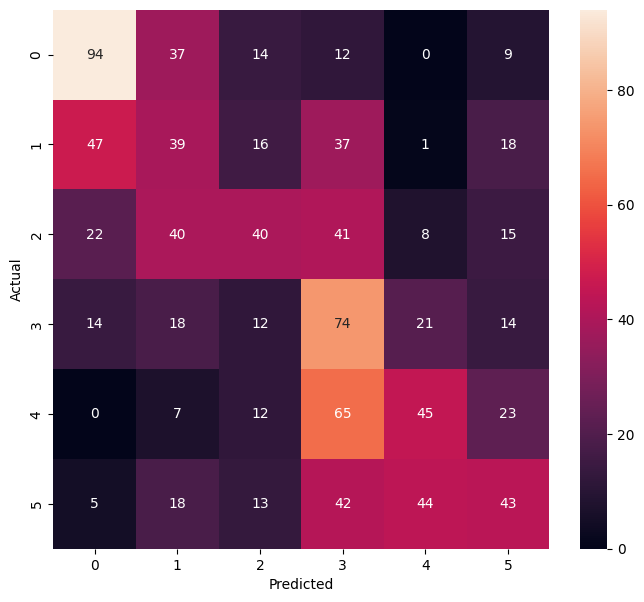

In [44]:
## Confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,7))
sns.heatmap(conf_mat, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

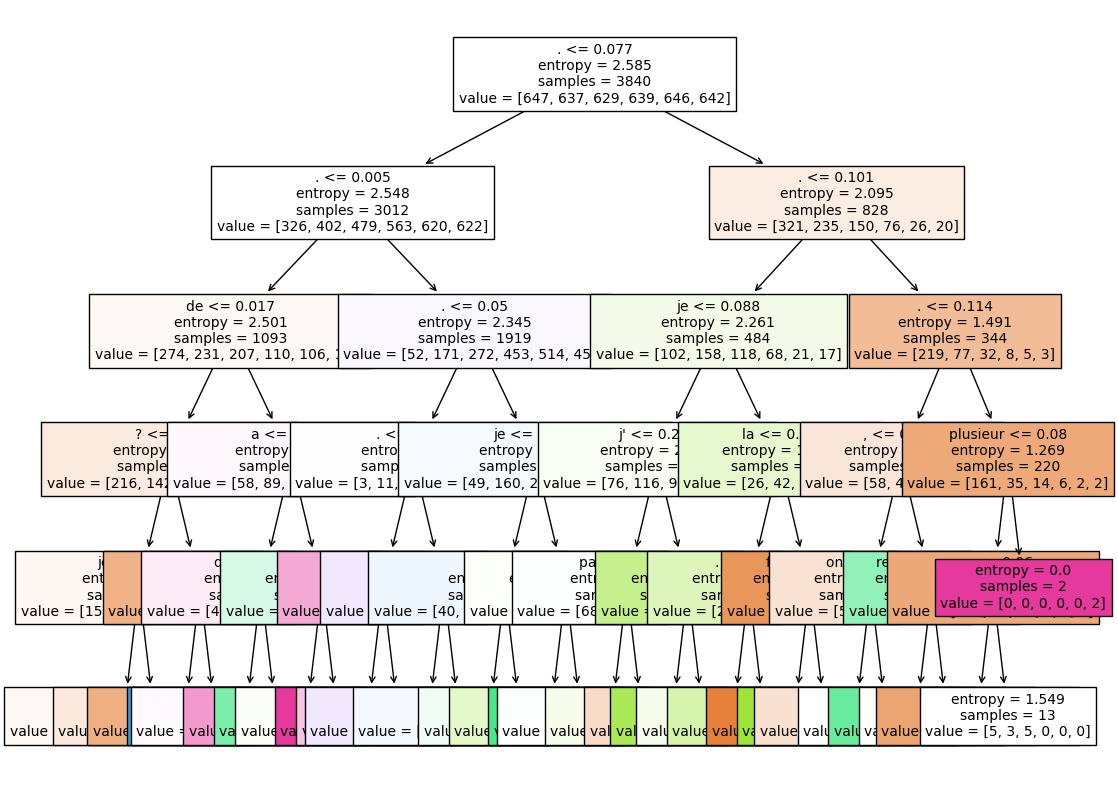

In [49]:
from sklearn.tree import plot_tree

tree_model = pipe.named_steps['clf']

plt.figure(figsize=(12,10))
feature_names = pipe.named_steps['vect'].get_feature_names_out()
plot_tree(tree_model, filled=True, feature_names=feature_names, fontsize=10)
plt.show()

# Train on full dataset

In [31]:
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

In [32]:
pipe.fit(X_full, y_full)

c:\Users\DENIZ\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function spacy_tokenizer at 0x00000299BBADF880>)),
                ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

# TEST DATA

In [33]:
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col = 'id')
df_pred.head()

,sentence
id,
0,Nous dûmes nous excuser des propos que nous eû...
1,Vous ne pouvez pas savoir le plaisir que j'ai ...
2,"Et, paradoxalement, boire froid n'est pas la b..."
3,"Ce n'est pas étonnant, car c'est une saison my..."
4,"Le corps de Golo lui-même, d'une essence aussi..."


In [34]:
df_pred['difficulty'] = pipe.predict(df_pred["sentence"])
predictions = df_pred.drop(columns=['sentence'], inplace = False)
#predictions.set_index('id',inplace = True)

predictions.to_csv('submission.csv')

In [35]:
predictions.head(2)

,difficulty
id,
0,C2
1,A2


In [36]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "Sample submission"

Successfully submitted to Detecting the difficulty level of French texts


  0%|          | 0.00/9.48k [00:00<?, ?B/s]
100%|██████████| 9.48k/9.48k [00:00<00:00, 11.8kB/s]
